<a href="https://colab.research.google.com/github/alexander-toschev/cv-course/blob/main/FD_Line_Detection_Hough.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Edge Detection using OpenCV

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.lines as mlines

import requests


In [ ]:
url = "https://skachatkartinki.net/photo/0-0/332_82585.jpg"
r = requests.get(url)
with open('test.jpg', 'wb') as f:
    f.write(r.content) 


url = "https://i.pinimg.com/736x/5c/ff/80/5cff802d48d74607ac929ec2751684e9--straight-lines.jpg"
r = requests.get(url)
with open('line.jpg', 'wb') as f:
    f.write(r.content) 

In [2]:
def line_detection_non_vectorized(image, edge_image, num_rhos=180, num_thetas=180, t_count=220):
  edge_height, edge_width = edge_image.shape[:2]
  edge_height_half, edge_width_half = edge_height / 2, edge_width / 2
  #
  d = np.sqrt(np.square(edge_height) + np.square(edge_width))
  dtheta = 180 / num_thetas
  drho = (2 * d) / num_rhos
  #
  thetas = np.arange(0, 180, step=dtheta)
  rhos = np.arange(-d, d, step=drho)
  #
  cos_thetas = np.cos(np.deg2rad(thetas))
  sin_thetas = np.sin(np.deg2rad(thetas))
  #
  accumulator = np.zeros((len(rhos), len(rhos)))
  #
  figure = plt.figure(figsize=(12, 12))
  subplot1 = figure.add_subplot(1, 4, 1)
  subplot1.imshow(image)
  subplot2 = figure.add_subplot(1, 4, 2)
  subplot2.imshow(edge_image, cmap="gray")
  subplot3 = figure.add_subplot(1, 4, 3)
  subplot3.set_facecolor((0, 0, 0))
  subplot4 = figure.add_subplot(1, 4, 4)
  subplot4.imshow(image)
  #
  for y in range(edge_height):
    for x in range(edge_width):
      if edge_image[y][x] != 0:
        edge_point = [y - edge_height_half, x - edge_width_half]
        ys, xs = [], []
        for theta_idx in range(len(thetas)):
          rho = (edge_point[1] * cos_thetas[theta_idx]) + (edge_point[0] * sin_thetas[theta_idx])
          theta = thetas[theta_idx]
          rho_idx = np.argmin(np.abs(rhos - rho))
          accumulator[rho_idx][theta_idx] += 1
          ys.append(rho)
          xs.append(theta)
        subplot3.plot(xs, ys, color="white", alpha=0.05)

  for y in range(accumulator.shape[0]):
    for x in range(accumulator.shape[1]):
      if accumulator[y][x] > t_count:
        rho = rhos[y]
        theta = thetas[x]
        a = np.cos(np.deg2rad(theta))
        b = np.sin(np.deg2rad(theta))
        x0 = (a * rho) + edge_width_half
        y0 = (b * rho) + edge_height_half
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        subplot3.plot([theta], [rho], marker='o', color="yellow")
        subplot4.add_line(mlines.Line2D([x1, x2], [y1, y2]))

  subplot3.invert_yaxis()
  subplot3.invert_xaxis()

  subplot1.title.set_text("Original Image")
  subplot2.title.set_text("Edge Image")
  subplot3.title.set_text("Hough Space")
  subplot4.title.set_text("Detected Lines")
  plt.show()
  return accumulator, rhos, thetas

def line_detection_vectorized(image, edge_image, num_rhos=180, num_thetas=180, t_count=220):
  edge_height, edge_width = edge_image.shape[:2]
  edge_height_half, edge_width_half = edge_height / 2, edge_width / 2
  #
  d = np.sqrt(np.square(edge_height) + np.square(edge_width))
  dtheta = 180 / num_thetas
  drho = (2 * d) / num_rhos
  #
  thetas = np.arange(0, 180, step=dtheta)
  rhos = np.arange(-d, d, step=drho)
  #
  cos_thetas = np.cos(np.deg2rad(thetas))
  sin_thetas = np.sin(np.deg2rad(thetas))
  #
  accumulator = np.zeros((len(rhos), len(rhos)))
  #
  figure = plt.figure(figsize=(12, 12))
  subplot1 = figure.add_subplot(1, 4, 1)
  subplot1.imshow(image)
  subplot2 = figure.add_subplot(1, 4, 2)
  subplot2.imshow(edge_image, cmap="gray")
  subplot3 = figure.add_subplot(1, 4, 3)
  subplot3.set_facecolor((0, 0, 0))
  subplot4 = figure.add_subplot(1, 4, 4)
  subplot4.imshow(image)
  #
  edge_points = np.argwhere(edge_image != 0)
  edge_points = edge_points - np.array([[edge_height_half, edge_width_half]])
  #
  rho_values = np.matmul(edge_points, np.array([sin_thetas, cos_thetas]))
  #
  accumulator, theta_vals, rho_vals = np.histogram2d(
      np.tile(thetas, rho_values.shape[0]),
      rho_values.ravel(),
      bins=[thetas, rhos]
  )
  accumulator = np.transpose(accumulator)
  lines = np.argwhere(accumulator > t_count)
  rho_idxs, theta_idxs = lines[:, 0], lines[:, 1]
  r, t = rhos[rho_idxs], thetas[theta_idxs]

  for ys in rho_values:
    subplot3.plot(thetas, ys, color="white", alpha=0.05)

  subplot3.plot([t], [r], color="yellow", marker='o')

  for line in lines:
    y, x = line
    rho = rhos[y]
    theta = thetas[x]
    a = np.cos(np.deg2rad(theta))
    b = np.sin(np.deg2rad(theta))
    x0 = (a * rho) + edge_width_half
    y0 = (b * rho) + edge_height_half
    x1 = int(x0 + 1000 * (-b))
    y1 = int(y0 + 1000 * (a))
    x2 = int(x0 - 1000 * (-b))
    y2 = int(y0 - 1000 * (a))
    subplot3.plot([theta], [rho], marker='o', color="yellow")
    subplot4.add_line(mlines.Line2D([x1, x2], [y1, y2]))

  subplot3.invert_yaxis()
  subplot3.invert_xaxis()

  subplot1.title.set_text("Original Image")
  subplot2.title.set_text("Edge Image")
  subplot3.title.set_text("Hough Space")
  subplot4.title.set_text("Detected Lines")
  plt.show()
  return accumulator, rhos, thetas

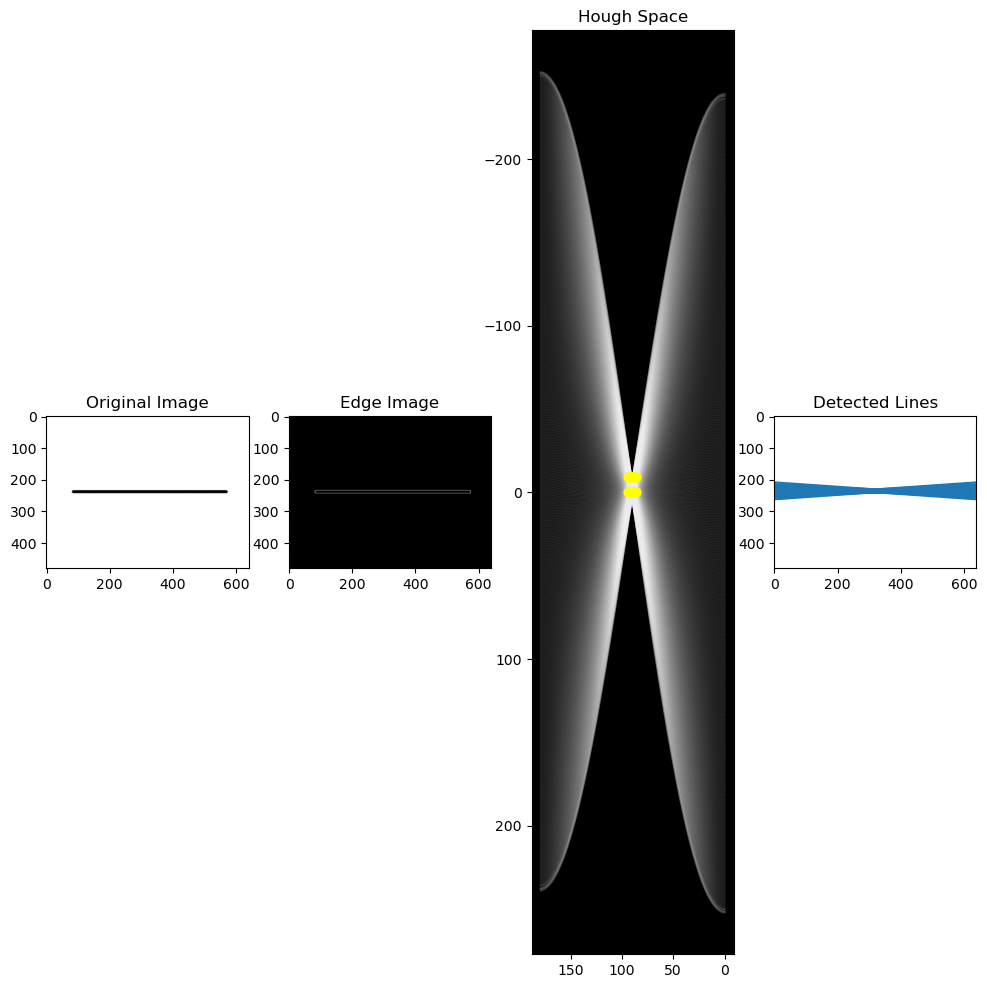

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-8.00000000e+02, -7.91111111e+02, -7.82222222e+02, -7.73333333e+02,
        -7.64444444e+02, -7.55555556e+02, -7.46666667e+02, -7.37777778e+02,
        -7.28888889e+02, -7.20000000e+02, -7.11111111e+02, -7.02222222e+02,
        -6.93333333e+02, -6.84444444e+02, -6.75555556e+02, -6.66666667e+02,
        -6.57777778e+02, -6.48888889e+02, -6.40000000e+02, -6.31111111e+02,
        -6.22222222e+02, -6.13333333e+02, -6.04444444e+02, -5.95555556e+02,
        -5.86666667e+02, -5.77777778e+02, -5.68888889e+02, -5.60000000e+02,
        -5.51111111e+02, -5.42222222e+02, -5.33333333e+02, -5.24444444e+02,
        -5.15555556e+02, -5.06666667e+02, -4.97777778e+02, -4.88888889e+02,
        -4.80000000e+02, -4.71111111e+02, -4.62222222e+02, -4.53333

In [3]:
img = cv2.imread('content/line.jpg')
edge_image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
edge_image = cv2.GaussianBlur(edge_image, (3, 3), 1)
edge_image = cv2.Canny(edge_image, 100, 200)
# https://www.javatpoint.com/opencv-erosion-and-dilation
#edge_image = cv2.dilate(
#        edge_image,
#        cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5)),
#        iterations=1
#)
#edge_image = cv2.erode(
#        edge_image,
#        cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5)),
#        iterations=1
#)
line_detection_vectorized(img, edge_image)

## Sobel Edge Detection

Нам необходимо найти быстрые изменения интенсивности пикселей.

Syntax: dst = cv2.Sobel(src, ddepth, dx, dy, ksize)
Where, ddepth is the depth of the destination image, dx is Horizontal sobel derivative, dy is vertical sobel derivative and ksize is the kernel size.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 639.5, 479.5, -0.5)

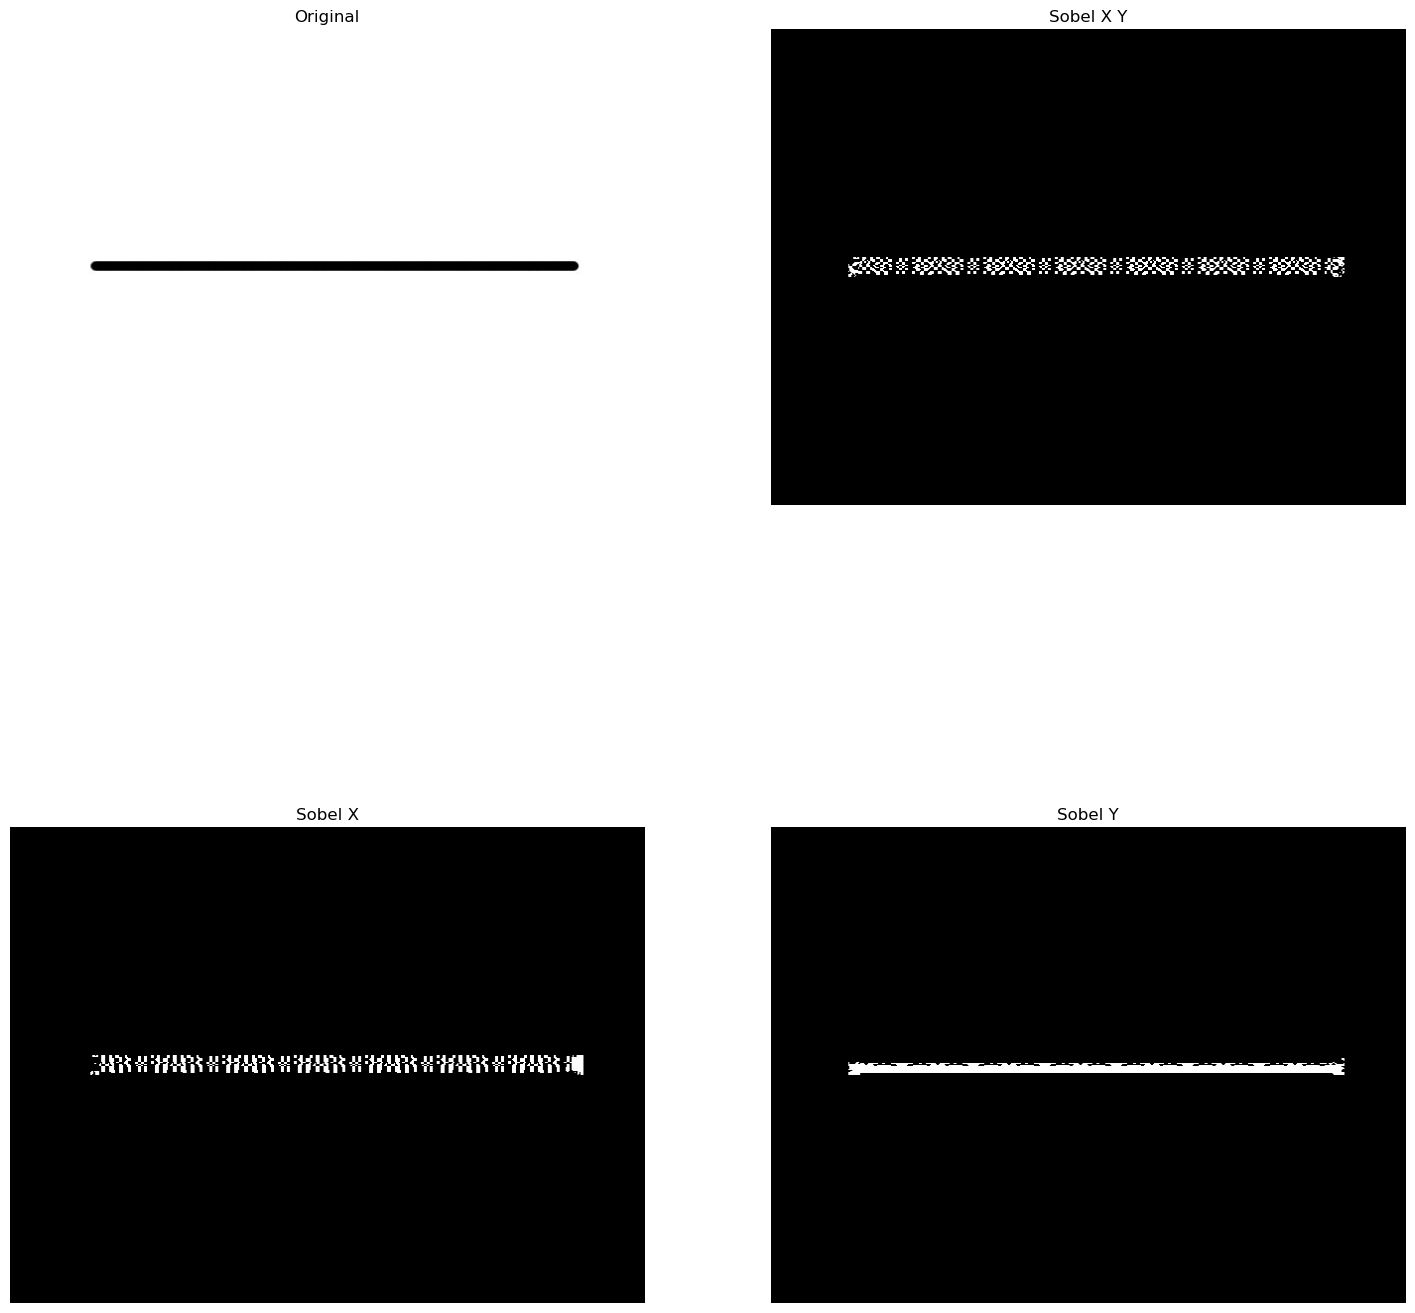

In [4]:
sobelx = cv2.Sobel(src=img, ddepth=cv2.CV_64F, dx=1, dy=0, ksize=5) 

sobely = cv2.Sobel(src=img, ddepth=cv2.CV_64F, dx=0, dy=1, ksize=5)

sobelxy = cv2.Sobel(src=img, ddepth=cv2.CV_64F, dx=1, dy=1, ksize=5)

plt.figure(figsize=(18,19))
plt.subplot(221)
plt.imshow(img, cmap='gray')
plt.title('Original') 
plt.axis("off")

plt.subplot(222)
plt.imshow(sobelxy, cmap='gray')
plt.title('Sobel X Y') 
plt.axis("off")

plt.subplot(223)
plt.imshow(sobelx, cmap='gray')
plt.title('Sobel X') 
plt.axis("off")

plt.subplot(224)
plt.imshow(sobely, cmap='gray')
plt.title('Sobel Y')
plt.axis("off")

## Canny Edge Detection

**Сглаживание**. Размытие изображения для удаления шума. Оператор Кэнни использует фильтр, который может быть хорошо приближен к первой производной гауссианы.  

$\sigma  = 1.4$:

$\displaystyle \mathbf {B} = \frac{1}{159} \begin{bmatrix}2&4&5&4&2\\4&9&12&9&4\\5&12&15&12&5\\4&9&12&9&4\\2&4&5&4&2\end{bmatrix}*A$


**Поиск градиентов**. Границы отмечаются там, где градиент изображения приобретает максимальное значение. Они могут иметь различное направление, поэтому алгоритм Кэнни использует четыре фильтра для обнаружения горизонтальных, вертикальных и диагональных ребер в размытом изображении.

${\displaystyle \mathbf {G} ={\sqrt {{\mathbf {G} _{x}}^{2}+{\mathbf {G} _{y}}^{2}}}}$

${\displaystyle \mathbf {\Theta } =\operatorname {arctg} \left({\mathbf {G} _{y} \over \mathbf {G} _{x}}\right).}$

Угол направления вектора градиента округляется и может принимать такие значения: 0, 45, 90, 135.

**Подавление немаксимумов**. Только локальные максимумы отмечаются как границы.

**Двойная пороговая фильтрация**. Потенциальные границы определяются порогами.

Трассировка области неоднозначности. Итоговые границы определяются путём подавления всех краёв, не связанных с определенными (сильными) границами.

Перед применением детектора обычно преобразуют изображение в оттенки серого, чтобы уменьшить вычислительные затраты. Этот этап характерен для многих методов обработки изображений.

Syntax: dest = cv2.canny(src, threshold1, threshold2)
Where, threshold1 is the the High threshold value of intensity gradient and threshold2 is the low threshold value of the intensity gradient.

(-0.5, 639.5, 479.5, -0.5)

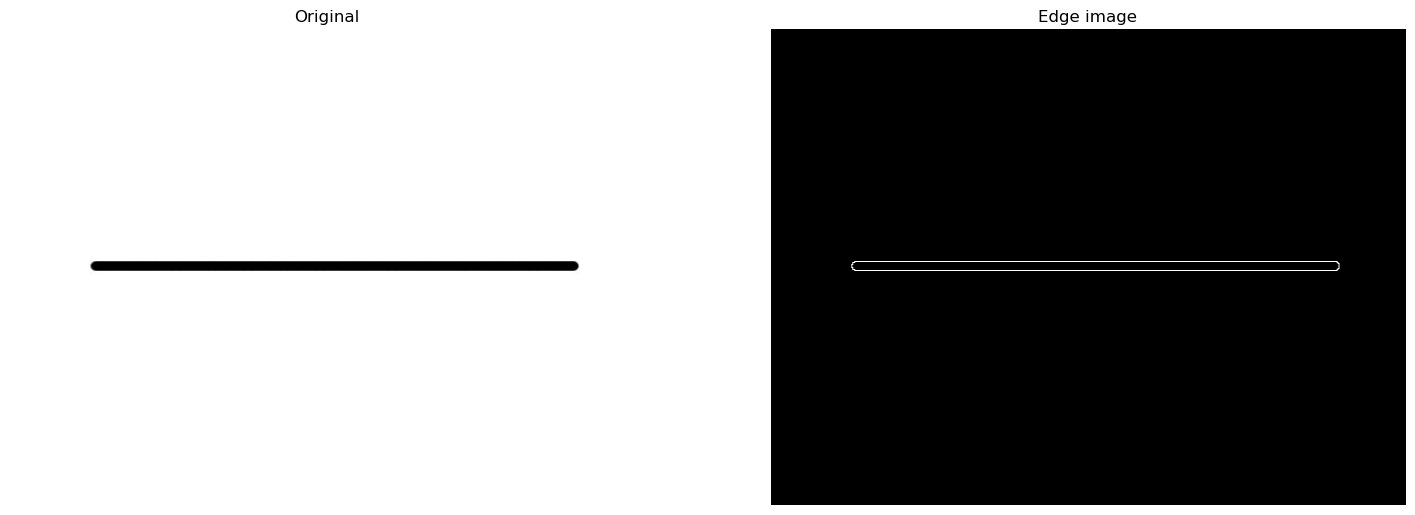

In [5]:
edges = cv2.Canny(image=img, threshold1=100, threshold2=200)

plt.figure(figsize=(18,19))
plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.title('Original') 
plt.axis("off")

plt.subplot(122)
plt.imshow(edges, cmap='gray')
plt.title('Edge image')
plt.axis("off")

**Задача**

Посчитайте количество объектов на картинке выше.